In [377]:
import os
import face_recognition
import numpy as np
import pandas as pd
from skimage import io
from helper.face_detection import detect_faces
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
%matplotlib inline

# Prepare Image Used

In [378]:
source_file = pd.read_csv("../data/train.csv")
training_path = "../data/raw/Training/{}"
data_observation_id = 48
observation_folder_path = training_path.format(source_file.loc[data_observation_id]["nomor"])
filenames = os.listdir(observation_folder_path)

In [379]:
images_path_inside_folder = ["../data/raw/Training/{}/{}".format(source_file.loc[data_observation_id]["nomor"], filename)  for filename in filenames]

In [380]:
images = [io.imread(image_path) for image_path in images_path_inside_folder ]
len(images)

3

In [381]:
faces_detected = [(n, detect_faces(img)) for n, img in enumerate(images)]
faces_detected

[(0, [(483, 469, 612, 598)]),
 (1, [(398, 94, 460, 156)]),
 (2, [(663, 146, 753, 236), (342, 152, 450, 259)])]

In [382]:
extracted_face_detected = []

for item in faces_detected:
    (img_index, face_rect) = item
    if len(face_rect) > 1:
        for face in face_rect:
             extracted_face_detected.append((img_index, face))
    else:
        extracted_face_detected.append((img_index, face_rect[0]))

extracted_face_detected[0]

(0, (483, 469, 612, 598))

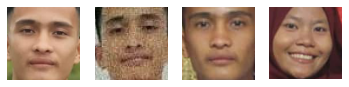

In [383]:
list_face_image = []
for n, (img_index, face_rect) in enumerate(extracted_face_detected):
    face = Image.fromarray(images[img_index]).crop(face_rect)
    list_face_image.append(face)
    plt.subplot(1, len(extracted_face_detected), n+1)
    plt.axis('off')
    plt.imshow(face)

In [384]:
len(list_face_image)

4

# Clustering Image

In [385]:
# encode image to array
list_encoded_face = [face_recognition.face_encodings(np.asarray(img)) for img in list_face_image]
# list_encoded_face_filtered = [np.array(filtered[0]) for filtered in list(filter(lambda encode: len(encode) > 0, list_encoded_face))]
list_encoded_face_filtered = [filtered[0] if len(filtered) else np.random.rand(128) for filtered in list_encoded_face]
# np.array(list_encoded_face_filtered[0]).shape

In [386]:
k_mean_cluster = KMeans(n_clusters=len(list_encoded_face_filtered)//2)
k_mean_cluster.fit(list_encoded_face_filtered)
k_mean_cluster.labels_

array([0, 0, 0, 1], dtype=int32)

In [387]:
dbscan_cluster = DBSCAN(min_samples = 2)
dbscan_cluster.fit(list_encoded_face_filtered)
dbscan_cluster.labels_

array([ 0,  0,  0, -1])

In [388]:
agglomerative_cluster = AgglomerativeClustering()
agglomerative_cluster.fit(list_encoded_face_filtered)
agglomerative_cluster.labels_


array([0, 0, 0, 1])

In [389]:
mode_label = stats.mode( np.array(dbscan_cluster.labels_))[0][0]
mode_label

0

In [390]:
filtered_label = [label == mode_label and mode_label != -1 for label in dbscan_cluster.labels_]
filtered_label

[True, True, True, False]

In [391]:
main_person_face = np.array(list_face_image)[filtered_label]
main_person_face

/tmp/ipykernel_6529/2776087418.py:1: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  main_person_face = np.array(list_face_image)[filtered_label]
/tmp/ipykernel_6529/2776087418.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_person_face = np.array(list_face_image)[filtered_label]


array([<PIL.Image.Image image mode=RGB size=129x129 at 0x7FB13B2A3A60>,
       <PIL.Image.Image image mode=RGB size=62x62 at 0x7FB13B301B80>,
       <PIL.Image.Image image mode=RGB size=90x90 at 0x7FB13AF595E0>],
      dtype=object)

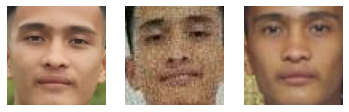

In [392]:
for n, img_face in enumerate(main_person_face):
    plt.subplot(1, len(main_person_face), n+1)
    plt.axis('off')
    plt.imshow(img_face)

/media/huntz/DATA/project/gender_classification/helper/image_clustering.py:17: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(list_face_image)[filtered_label]
/media/huntz/DATA/project/gender_classification/helper/image_clustering.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(list_face_image)[filtered_label]


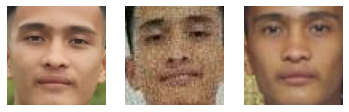

In [394]:
from helper.image_clustering import image_clustering

main_face = image_clustering(list_face_image)

for n, img_face in enumerate(main_face):
    plt.subplot(1, len(main_person_face), n+1)
    plt.axis('off')
    plt.imshow(img_face)